# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print('Всего по итогу обработки изображений получено батчей:', len(train_gen_flow))

Всего по итогу обработки изображений получено батчей: 238


In [4]:
features_train, target_train = next(train_gen_flow)

In [5]:
print('Размер выборки для 1-го батча составляет', features_train.shape)

Размер выборки для 1-го батча составляет (32, 224, 224, 3)


In [6]:
target_train

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


[Text(0.5, 0, 'Возраст'), Text(0, 0.5, 'Количество людей')]

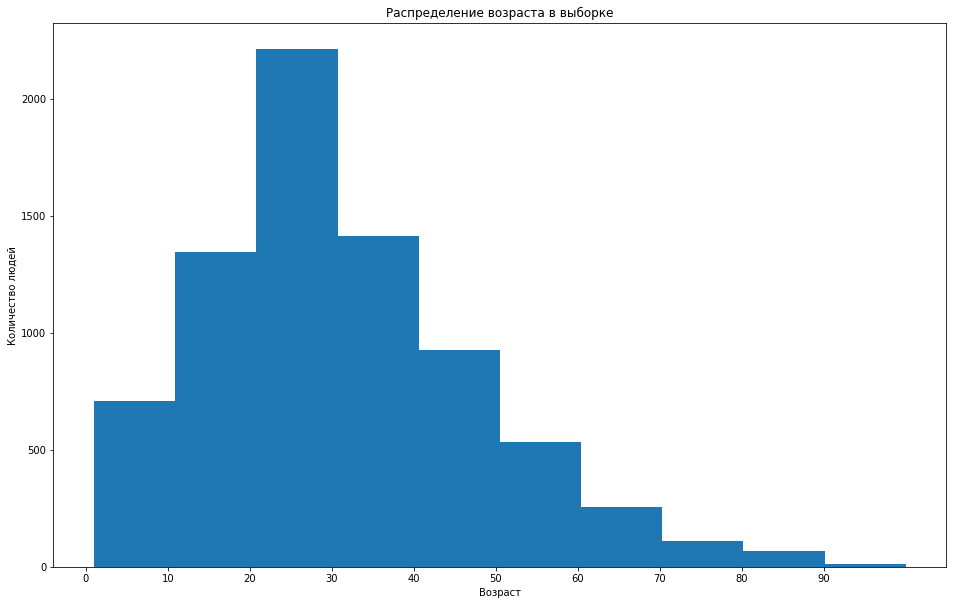

In [8]:
plt.figure(figsize=(16, 10))
plt.hist(labels['real_age'], bins=10)
plt.xticks(np.arange(0, 100, step=10))
plt.title("Распределение возраста в выборке")
plt.gca().set(xlabel='Возраст', ylabel='Количество людей')

Из графика видно, что:

в выборке мало пожилых людей и детей;
медиана и среднее практически одинаковы (выбросы отсутствуют).

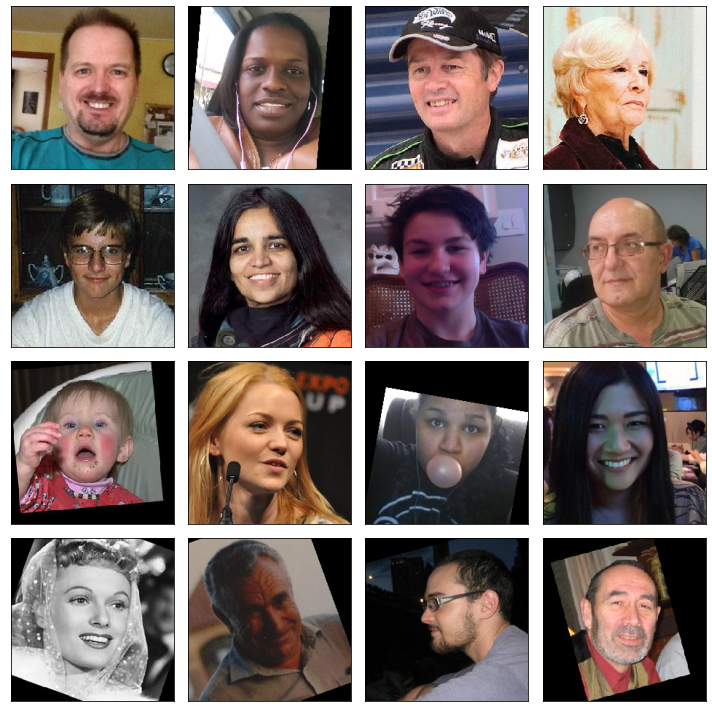

In [9]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

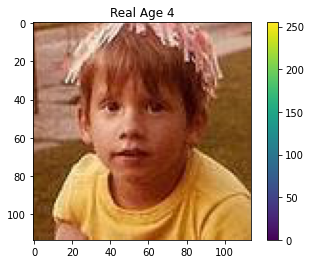

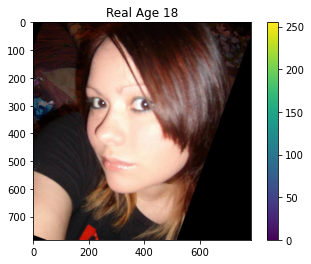

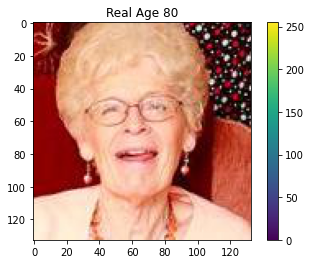

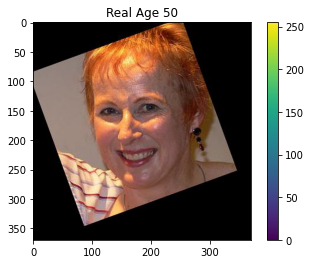

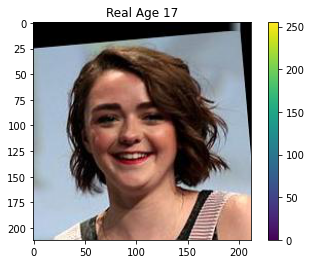

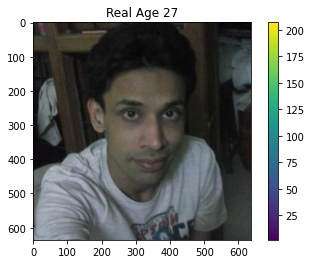

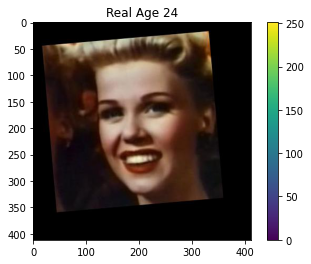

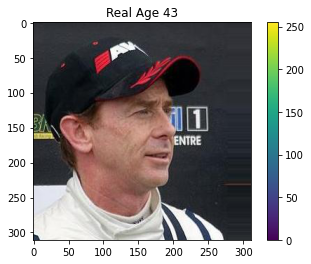

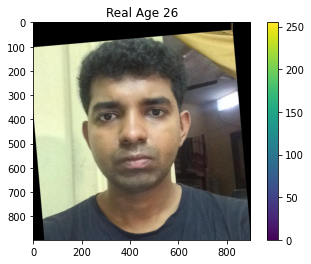

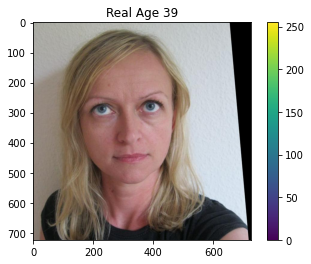

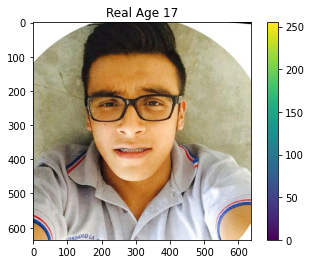

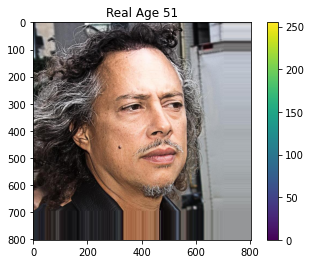

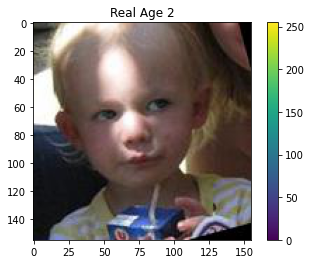

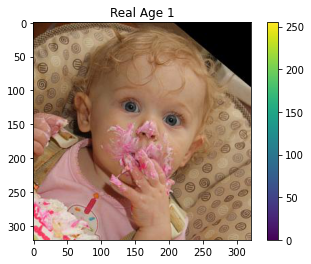

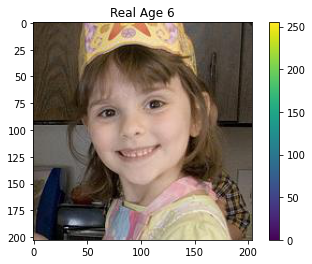

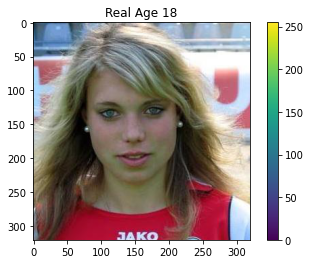

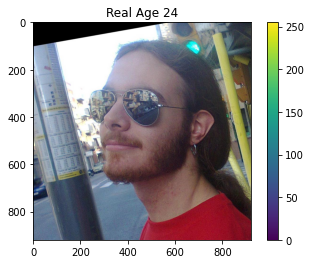

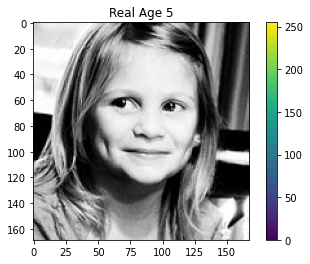

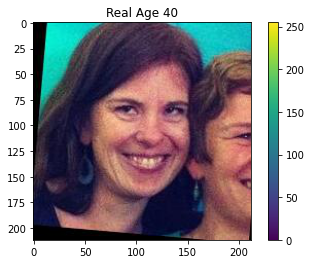

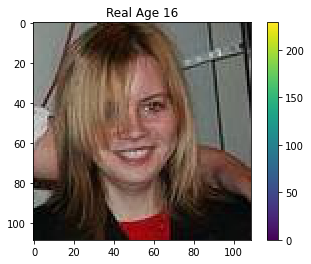

In [10]:
from PIL import Image
for i,k in zip(labels.file_name[:20],labels.real_age[:20]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.colorbar()
    plt.show()

**Вывод:**

Видим, что фотографии в выборке очень разнообразные

В нашем распоряжении датасет с 7591 фотографий с размером 224Х224. 
Среди них есть повернутые изображений по горизонтали, а также мы видим изображения в оттенках серого и красного, встречаются чернобелые фото и с размытием области. 

In [11]:
target_train[:16]

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58])

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Полученная модель преодолела необходимый порог по метрике MAE в 7.691 (установленный зазказчиком порог - 8 лет). Заказчиком поставлены 2 задачи:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

С первой задачей модель с полученной метрикой справится вполне успешно, также в качестве одного из вариантов можно предложить заказчику определять не точный возраст, а разбить всех покупателей на группы по возрасту (к примеру, по 7 лет), что преобразует задачу регрессии в задачу многклассовой классификации.

Вторую задачу при такой метрике невозможно решить точно, потому что модель может сильно ошибиться с возрастом детей и подростков, что не позволит проконтролировать добросовестность кассиров при продаже алкоголя. В качестве одного из вариантов, можно проинструктировать кассиров проверять всех, кому по их мнению менее 24 лет (18 + 6, где 6 - ошибка модели). В таком случае модель может быть применена.